<a href="https://colab.research.google.com/github/JesusRomeroRivera/cc41-tf-201910711-201910295-201911572-201910149-201914885/blob/main/TF_Complejidad_Algoritmica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**GRAFO INICIAL**

In [159]:
import graphviz as gv
import numpy as np
import pandas as pd
import heapq as hq
import numpy.random as npr
import matplotlib.pyplot as plt
import collections as col
import networkx as nx
import math
import csv

In [1]:
def generar_ciudad(tamaño):
  G = [[] for _ in range(tamaño**2)]
  final = False
  for i in range(tamaño ** 2):
    if i % tamaño == 0:
      G[i].append(i+1)
    elif (i + 1) % tamaño == 0:
      G[i].append(i-1)
    else:
      G[i].append(i+1)
      G[i].append(i-1)
    if (tamaño - 1)*tamaño == i:
      final = True
    if not final:
      G[i].append(i+tamaño)
      G[i + tamaño].append(i)
  identificador = ["N" for _ in range(tamaño**2)]
  return G, identificador

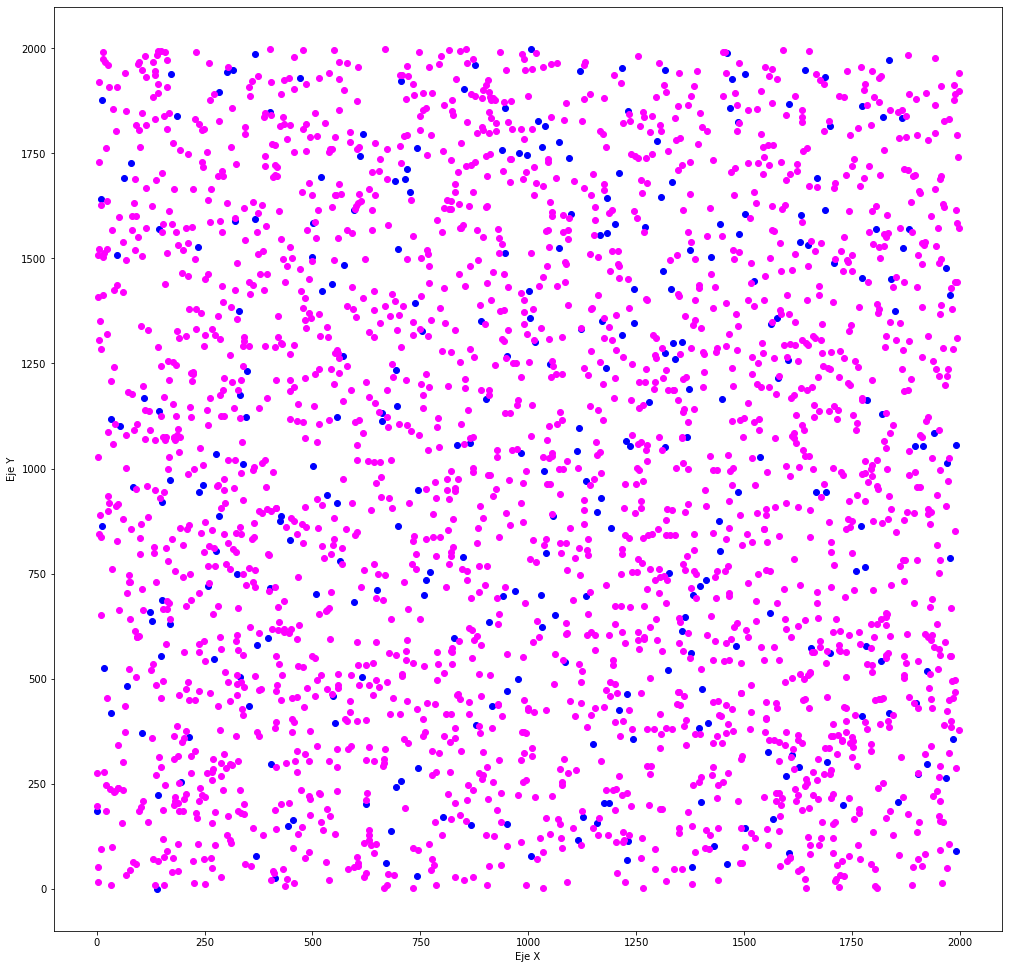

In [93]:
G, identificador = generar_ciudad(2800)
almacenes = pd.read_csv("almacenes.csv", header=None).to_numpy()
pEntrega = pd.read_csv("puntos_entrega.csv", header=None).to_numpy()
plt.subplots(figsize=(17, 17))
plt.ylabel('Eje Y')
plt.xlabel('Eje X')
plt.scatter(almacenes[:, 0], almacenes[:, 1], color = "blue")
plt.scatter(pEntrega[:, 0], pEntrega[:, 1], color = "magenta")

**FUNCIONES**

In [202]:
def manhattan_distance(a, b):
  return abs(a[0] - b[0]) + abs(a[1] - b[1])

In [6]:
def get_grupo(coord, size):
  return int(coord[0] + size*coord[1])

In [7]:
pEntrega_por_almacen = len(pEntrega) / len(almacenes)
pEntrega_aux = list(pEntrega)
grupos = []
grupo = dict()
j= (int)(pEntrega_por_almacen)
for almacen in almacenes:
  pEntrega_aux.sort(key=lambda pEntrega: manhattan_distance(almacen, pEntrega))
  grupo["puntosEntrega"] = pEntrega_aux[:8]
  grupo["almacen"] = almacen
  pEntrega_aux = pEntrega_aux[8:]
  grupos.append(grupo.copy())

In [175]:
def coordenadas(node, size):
  x = node % size
  y = (node - x)/size
  return (int(x), int(y))

**MOSTRAR GRUPO DE ALMACEN** 

In [8]:
def MostrarGrupo(L, labels=None, directed=False, weighted=False, path=[],
             layout="sfdp"):
  g = gv.Digraph("G") if directed else gv.Graph("G")
  g.graph_attr["layout"] = layout; g.edge_attr["color"] = "red"; g.node_attr["color"] = "green"; 
  g.node_attr["width"] = "0.2"; g.node_attr["height"] = "0.2"; g.node_attr["fontsize"] = "9"; 
  g.node_attr["fontcolor"] = "black"; g.node_attr["fontname"] = "monospace"; 
  g.edge_attr["fontsize"] = "9"; g.edge_attr["fontname"] = "monospace"
  n = len(L)
  for u in range(n):
    g.node(str(u), labels[u] if labels else str(u))
  added = set()
  for v, u in enumerate(path):
    if(u == -1 or u == None): continue
    if u != None:
      if weighted:
        for vi, w in L[u]:
          if vi == v:
            break
        g.edge(str(u), str(v), str(w), dir="forward", penwidth="2.5", color="purple")
      else:
        g.edge(str(u), str(v), dir="forward", penwidth="2.5", color="purple")
      added.add(f"{u},{v}")
      added.add(f"{v},{u}")
  if weighted:
    for u in range(n):
      for v, w in L[u]:
        if not directed and not f"{u},{v}" in added:
          added.add(f"{u},{v}")
          added.add(f"{v},{u}")
          g.edge(str(u), str(v), str(w))
        elif directed:
          g.edge(str(u), str(v), str(w))
  else:
    for u in range(n):
      for v in L[u]:
        if not directed and not f"{u},{v}" in added:
          added.add(f"{u},{v}")
          added.add(f"{v},{u}")
          g.edge(str(u), str(v))
        elif directed:
          g.edge(str(u), str(v))
  return g

**DIJKSTRA**

In [182]:
def dijkstra(G, s):
  n = len(G)
  visited = [False]*n
  path = [None]*n
  cost = [math.inf]*n
  cost[s] = 0
  queue = [(0, s)]
  while queue:
    g_u, u = hq.heappop(queue)
    if not visited[u]:
      visited[u] = True
      for v, w in G[u]:
        f = g_u + w
        if f < cost[v]:
          cost[v] = f
          path[v] = u
          hq.heappush(queue, (f, v))
  return path, cost

In [183]:
def dijkstra_grupo(grupo, plt=None, ciudad = 60):
  nodelist = grupo["puntosEntrega"]
  nodelist.append(grupo["almacen"])
  label = list()
  for nodo in nodelist:
    label.append(str(get_grupo(nodo,ciudad)))
  grafo = [[] for _ in range(len(nodelist))]
  for i, _ in enumerate(nodelist):
    for j, _ in enumerate(nodelist):
      if i == j: continue
      grafo[i].append((j, manhattan_distance(nodelist[i], nodelist[j])))
  path, cost = dijkstra(grafo, len(nodelist) - 1)
  if(plt == None): return MostrarGrupo(grafo, weighted=True, path=path, labels=label)
  else: 
    for i in range(len(path)):
      a = coordenadas(int(label[i]), ciudad)
      b = coordenadas(int(label[path[i]]), ciudad)
      plt.plot([a[0], b[0]], [a[1], b[1]])

**PRIM**

In [187]:
def prim(G):
  n = len(G)
  visited = [False]*n
  path = [-1]*n
  cost = [math.inf]*n
  q = [(0, 0)]
  while q:
    _, u = hq.heappop(q)
    if not visited[u]:
      visited[u] = True
      for v, w in G[u]:
        if not visited[v] and w < cost[v]:
          cost[v] = w
          path[v] = u
          hq.heappush(q, (w, v))

  return path, cost

In [188]:
def prim_grupo(grupo, plt=None, ciudad = 60):
  
  nodelist = grupo["puntosEntrega"]
  nodelist.append(grupo["almacen"])
  label = list()
  for nodo in nodelist:
    label.append(str(get_grupo(nodo,ciudad)))
  grafo = [[] for _ in range(len(nodelist))]
  for i, _ in enumerate(nodelist):
    for j, _ in enumerate(nodelist):
      if i == j: 
        continue
      grafo[i].append((j, manhattan_distance(nodelist[i], nodelist[j])))
  path, cost = prim(grafo)
  if(plt == None): return MostrarGrupo(grafo, weighted=True, path=path, labels=label)
  else: 
    for i in range(len(path)):
      a = coordenadas(int(label[i]), ciudad)
      b = coordenadas(int(label[path[i]]), ciudad)
      plt.plot([a[0], b[0]], [a[1], b[1]])

**BFS**

In [191]:
def bfs(G,s):  
    P,Q={s:None},col.deque([s])  
    while Q:  
        u=Q.popleft()  
        for v in G[u]:  
            if v in P:continue  
            P[v]=u  
            Q.append(v)  
    return P 

In [192]:
def bfs_grupo(grupo, plt=None, ciudad = 60):
  nodelist = grupo["puntosEntrega"]
  nodelist.append(grupo["almacen"])
  label = list()
  for nodo in nodelist:
    label.append(str(get_grupo(nodo, ciudad)))
  grafo = [[] for _ in range(len(nodelist))]
  for i, _ in enumerate(nodelist):
    for j, _ in enumerate(nodelist):
      if i == j: continue
      grafo[i].append((j, manhattan_distance(nodelist[i], nodelist[j])))
  path = bfs(grafo, len(nodelist) - 1)
  if(plt == None): return MostrarGrupo(grafo, weighted=True, path=path, labels=label)
  else: 
    for i in range(len(path)):
      a = coordenadas(int(label[i]), ciudad)
      b = coordenadas(int(label[path[i]]), ciudad)
      plt.plot([a[0], b[0]], [a[1], b[1]])

**DFS**

In [194]:
def dfs(G):
    S,res=set(),[]

    def recurse(u):
        if u in S: return
        S.add(u)
        for v in G[u]:
            recurse(v)
        res.append(u)

    for u in G:
        recurse(u)
    res.reverse()

    return res

In [196]:
def dfs_grupo(grupo, plt=None, ciudad = 60):
  nodelist = grupo["puntosEntrega"]
  nodelist.append(grupo["almacen"])
  label = list()
  for nodo in nodelist:
    label.append(str(get_grupo(nodo, ciudad)))
  grafo = [[] for _ in range(len(nodelist))]
  for i, _ in enumerate(nodelist):
    for j, _ in enumerate(nodelist):
      if i == j: continue
      grafo[i].append((j, manhattan_distance(nodelist[i], nodelist[j])))
  path = dfs(grafo)
  if(plt == None): return MostrarGrupo(grafo, weighted=True, path=path, labels=label)
  else: 
    for i in range(len(path)):
      a = coordenadas(int(label[i]), ciudad)
      b = coordenadas(int(label[path[i]]), ciudad)
      plt.plot([a[0], b[0]], [a[1], b[1]])

**UCS**

In [177]:
G = nx.read_weighted_edgelist('1.csv', create_using=nx.DiGraph, delimiter=',', nodetype=int)
def UCS(G, s):
  for u in G.nodes:
    G.nodes[u]['visited'] = False
    G.nodes[u]['path']    = -1
    G.nodes[u]['cost']    = math.inf

  G.nodes[s]['cost'] = 0
  q = [(0, s)]
  while q:
    g_u, u = hq.heappop(q)
    if not G.nodes[u]['visited']:
      G.nodes[u]['visited'] = True
      for v in G.neighbors(u):
        if not G.nodes[v]['visited']:
          w_uv = G.edges[u, v]['weight']
          f_v  = g_u + w_uv
          g_v  = G.nodes[v]['cost']
          if f_v < g_v:
            G.nodes[v]['cost'] = f_v
            G.nodes[v]['path'] = u
            hq.heappush(q, (f_v, v))

  path = [0]*G.number_of_nodes()
  for v, info in G.nodes.data():
    path[v] = info['path']

  return path

In [198]:
def ucs_grupo(grupo, plt=None, ciudad=60):
  nodelist = grupo["puntosEntrega"]
  nodelist.append(grupo["almacen"])
  label = list()
  for nodo in nodelist:
    label.append(str(get_grupo(nodo, ciudad)))
  grafo = [[] for _ in range(len(nodelist))]
  for i, _ in enumerate(nodelist):
    for j, _ in enumerate(nodelist):
      if i == j: continue
      grafo[i].append((j, manhattan_distance(nodelist[i], nodelist[j])))
  path = UCS(grafo, len(nodelist) - 1)
  if(plt == None): return MostrarGrupo(grafo, weighted=True, path=path, labels=label)
  else: 
    for i in range(len(path)):
      a = coordenadas(int(label[i]), ciudad)
      b = coordenadas(int(label[path[i]]), ciudad)
      plt.plot([a[0], b[0]], [a[1], b[1]])

In [200]:
ucs_grupo(grupos[23],None,60)

AttributeError: ignored

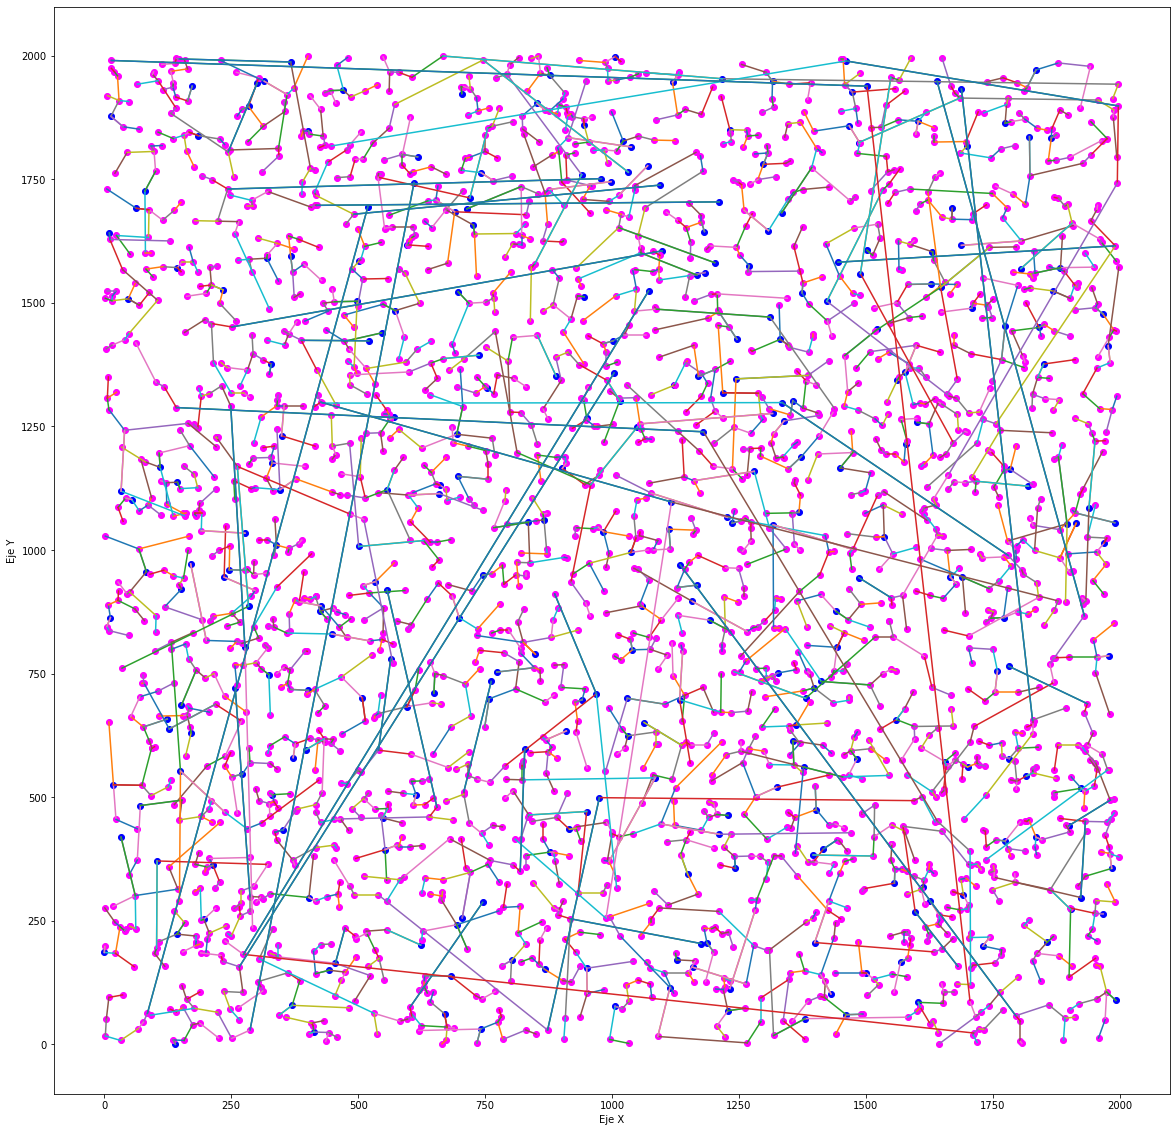

In [201]:
plt.subplots(figsize=(20, 20))
plt.ylabel('Eje Y')
plt.xlabel('Eje X')
for grupo in grupos:
  prim_grupo(grupo, plt, 2800)
plt.scatter(almacenes[:, 0], almacenes[:, 1], color = "blue")
plt.scatter(pEntrega[:, 0], pEntrega[:, 1], color = "magenta")